In [1]:
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


In [22]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 32, 32, 1) (60000,)
(10000, 32, 32, 1) (10000,)


In [3]:
# 이미지 전처리 
import numpy as np

def preprocessing(imgs):
    imgs = imgs.astype('float32') / 255.0
    # padding -> 60000 + 0 + 0, 28 + 2 + 2 , 28 + 2 + 2 => (60000, 32, 32)
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    # add channel dimension
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)


In [4]:
print(x_train.shape, x_test.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1)


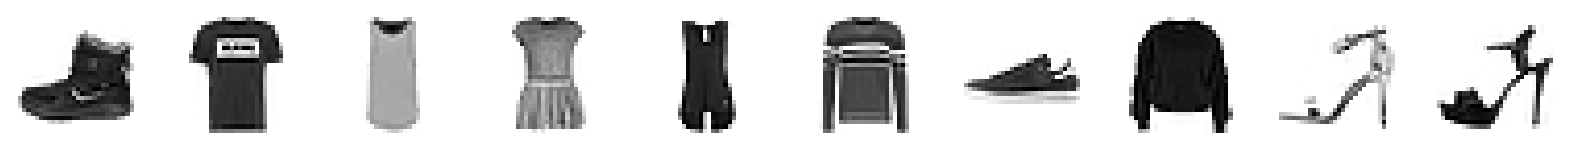

In [26]:
from utils import display

display(x_train)

In [27]:
# 인코더
import keras
import keras.backend as K

encoder_input = keras.layers.Input(shape = (32, 32, 1))
x = keras.layers.Conv2D(32, (3,3), strides = 2, activation = 'relu', padding = 'same')(encoder_input)
x = keras.layers.Conv2D(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = keras.layers.Conv2D(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

# none dimension 처리
shape_before_flattening = K.int_shape(x)[1:]
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(2)(x)

encoder = keras.models.Model(encoder_input, encoder_output)
encoder.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable

In [6]:
print(shape_before_flattening)

(4, 4, 128)


In [7]:
print(np.prod(shape_before_flattening))

2048


In [29]:
# 디코더

decoder_input = keras.layers.Input(shape = (2,))
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = keras.layers.Reshape(shape_before_flattening)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = keras.layers.Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = keras.layers.Conv2DTranspose(32, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

decoder_output = keras.layers.Conv2D(1, (3,3), strides = 1, activation = 'sigmoid', padding = 'same')(x)
decoder = keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 8, 8, 128)        147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 16, 16, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 32, 32, 32)       1846

In [20]:
decoder_input = keras.layers.Input(shape = (2,))
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = keras.layers.Reshape(shape_before_flattening)(x)
x = keras.layers.Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = keras.layers.Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)
x = keras.layers.Conv2DTranspose(32, (3,3), strides = 2, activation = 'relu', padding = 'same')(x)

decoder_output = keras.layers.Dense(1, activation="sigmoid")(x) # binary activation output
decoder = keras.models.Model(decoder_input, decoder_output)


In [21]:
print(decoder_output.shape)

(None, 32, 32, 1)


In [30]:
# auto-encoder

autoencoder = keras.models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 4098      
                                                                 
 model_9 (Functional)        (None, 32, 32, 1)         246

In [32]:
# train autoencoder

# model compile
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# train - fit method
history = autoencoder.fit(x_train, x_train, epochs = 10, batch_size = 100, shuffle = True, validation_data = (x_test, x_test))

Epoch 1/10


2024-03-25 18:23:40.037939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<100x32x32x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<100x32x32x1xi1

600/600 [==============================] - ETA: 0s - loss: 0.2920

2024-03-25 18:23:58.484720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<100x32x32x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<100x32x32x1xi1

600/600 [==============================] - 20s 26ms/step - loss: 0.2920 - val_loss: 0.2597
Epoch 2/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2562 - val_loss: 0.2554
Epoch 3/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2528 - val_loss: 0.2536
Epoch 4/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2511 - val_loss: 0.2520
Epoch 5/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2498 - val_loss: 0.2507
Epoch 6/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2491 - val_loss: 0.2506
Epoch 7/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2483 - val_loss: 0.2495
Epoch 8/10
600/600 [==============================] - 15s 26ms/step - loss: 0.2479 - val_loss: 0.2498
Epoch 9/10
600/600 [==============================] - 15s 26ms/step - loss: 0.2474 - val_loss: 0.2492
Epoch 10/10
600/600 [==============================] - 15s 26ms/step - loss: 0.2469 - val_los

157/157 [==============================] - 1s 8ms/step


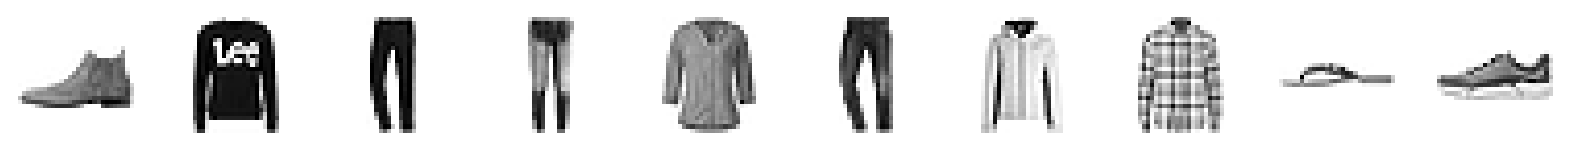

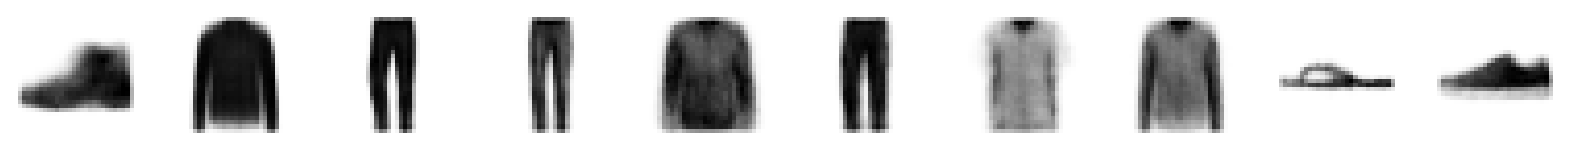

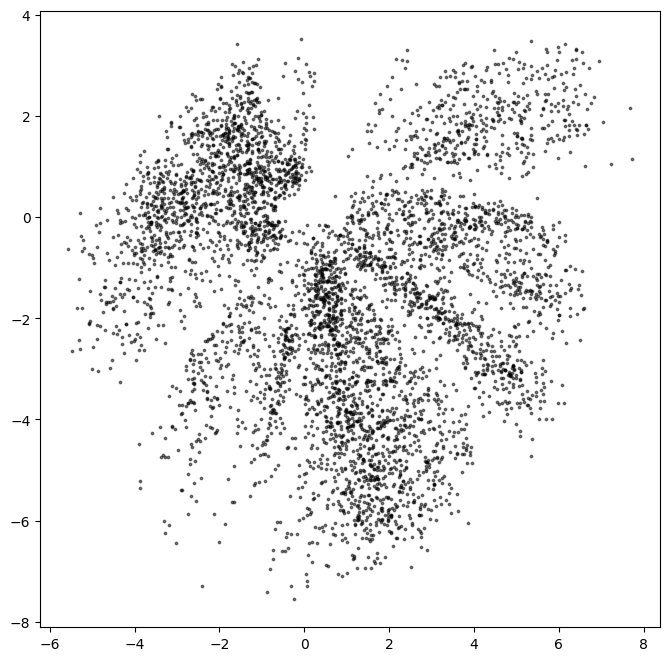

In [36]:
import matplotlib.pyplot as plt

# 이미지 재구성
example_images = x_test[:5000]
embeddings = encoder.predict(example_images)
predictions = autoencoder.predict(example_images)

display(example_images)
display(predictions)

# visualize latent space
plt.figure(figsize = (8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha = 0.5, s =3)
plt.show()


1/1 [==============================] - 0s 13ms/step


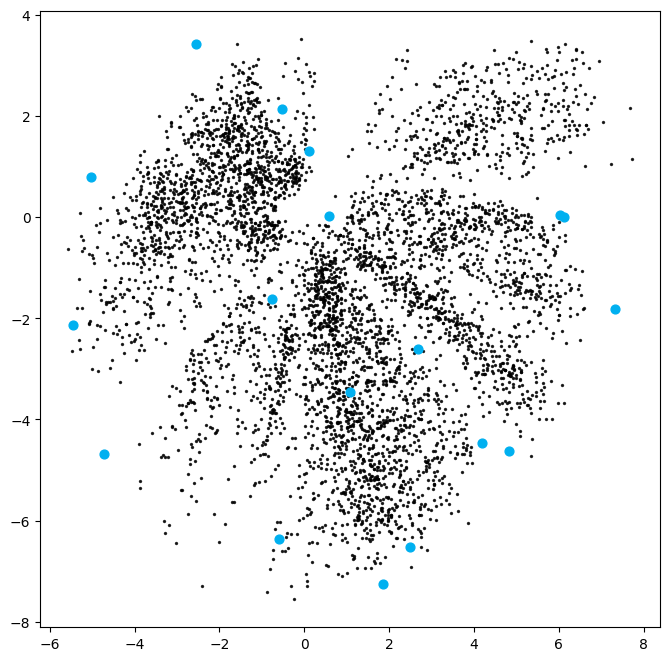

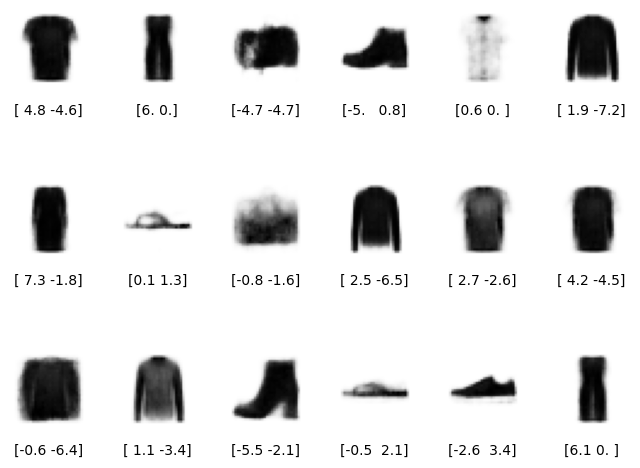

In [39]:
# sampling -> decoder infer
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18,2))
reconstructions = decoder.predict(sample)

# 그래프로 그립니다.
figsize = 8
plt.figure(figsize=(figsize, figsize))

# 원본 임베딩 
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.8, s=2)

# 잠재 공간에서 새로 생성된 포인트
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드 추가
grid_width, grid_height = (6, 3)
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")